# Las ecuaciones de la mecánica del suelo poroso elástico


Para el siguiente ejemplo, resolveremos las ecuaciones de Biot de suelo elástico poroso. Este problema combina muchos de los desafíos de nuestro problemas previamente estudiados: resuelve la mecánica de sólidos para la deformación del dominio, así como una simplificación de las ecuaciones de Navier-Stokes incompresibles para la infiltración del agua dentro del medio poroso deformable. La interacción dinámica entre el fluido y el sólido en el mismo medio da la respuesta necesaria en la mecánica de suelos.

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

## __El problema PDE__

Las ecuaciones forman un sistema de ecuaciones para la velocidad del fluido $\boldsymbol{u}_f$, la presión $p$ y los desplazamientos del medio $\boldsymbol{u}_s$:

\begin{align}
  \nabla \cdot \boldsymbol{\sigma}_{e} - \alpha\nabla p = \boldsymbol{f}, \\
  s \frac{\partial p}{\partial t} + \alpha \frac{\nabla \cdot \boldsymbol{u}_f}{\partial t}+ \nabla \cdot \frac{k}{\mu} \nabla p=\boldsymbol{q}.
\end{align}

El lado derecho $f$ es una fuerza dada por unidad de volumen y al igual que las ecuaciones de elasticidad lineal,
$\sigma_e(\boldsymbol{u}_s)$ denota el tensor de tensión o esfuerzos, que para un sólido elástico está dado por

\begin{equation}
  \sigma_e(\boldsymbol{u}_s) = \lambda \text{tr}(\boldsymbol{\epsilon}(\boldsymbol{u}_s)) +2\mu\boldsymbol{\epsilon}(\boldsymbol{u}_s)  \boldsymbol{I},
\end{equation}

donde $\boldsymbol{\epsilon}(\boldsymbol{u})$ es el tensor de deformación

\begin{equation} \boldsymbol{\epsilon}(\boldsymbol{u}_s) = \frac{1}{2}\left(\nabla \boldsymbol{u}_s + (\nabla \boldsymbol{u}_s)^T\right).\end{equation}

Los parámetros $\lambda$ y $\mu$ son los parámetros de Lamé respectivamente. Tenga en cuenta que hay dos ecuaciones de conservación de la cantidad de movimiento lineal: la del medio poroso elástico y la del fluido. La diferencia está en el términos adicional $\nabla p$ relativo a la presión dentro del medio elástico, así como de los términos transitorios en la del fluido. Los dos términos adicionales equilibran las fuerzas $F = \nabla\cdot\boldsymbol{\sigma} + \boldsymbol{f}$ por unidad de volumen en la segunda ley del movimiento de Newton.

Algunos otros parámetros físicos incluidos en el modelo son los siguientes:


*   $\alpha = 1-\beta_s/\beta_m $ número de BIOT.

*   $\beta_s =  $ compresibidad del solido.

*   $\beta_m =$ compresibidad del medio poroso. 

*   $s = (\alpha -\phi)\beta_s +\beta_f \phi $  es el coeficiente inercial.

*   $\phi$  porosidad del medio.

*   $\beta_f $ compresibidad del fluido.



## __Formulaciones variacionales__

La formulación variacional implica multiplicar por funciones de test apropiadas e integrar en el dominio. También se realiza un procedimiento de integración por partes en los términos que así lo requieran:

\begin{align}
\int_{\Omega} \nabla \boldsymbol{\sigma} : \nabla \boldsymbol{v} dx- \int_{\Omega} \alpha p (\nabla \cdot \boldsymbol{v}) dx =& \int_{\Omega} \boldsymbol{f}\cdot\boldsymbol{v}\: dx +\int_{\partial\Omega} (\boldsymbol{n} \cdot \boldsymbol{\sigma})\cdot\boldsymbol{v} d\partial ds ,\\
\int_{\Omega} s \frac{p_{n}-p_{n-1}}{\Delta t} w\: dx + \int_{\Omega} \alpha \frac{\nabla \cdot (\boldsymbol{u}_{n}-\boldsymbol{u}_{n-1})}{\Delta t}w\:dx + \int_{\Omega} \nabla w \cdot \frac{k}{\mu} \nabla p \: dx = & -\int_{\partial\Omega} \frac{k}{\mu}pn w\; ds.
\end{align}


## __Implementación FEniCS__ 

### __Problema de prueba 1: Hincamiento de un pilote__

Como primer problema de prueba, calculamos el hincamiento de un pilote en el suelo. Modelamos el dominio como un problema bidimensional.

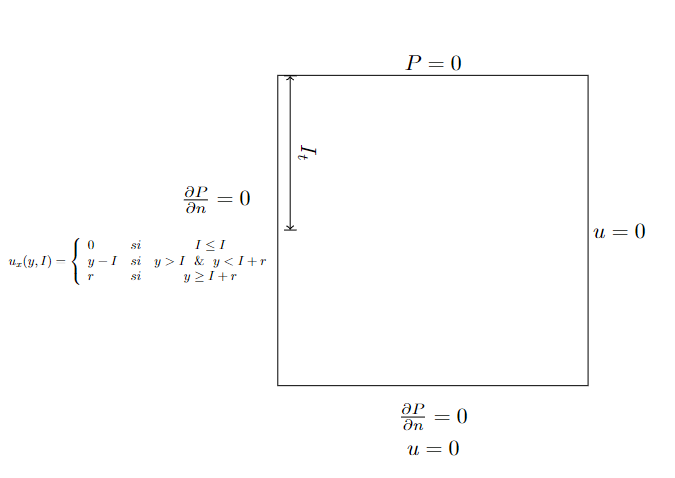

Se plantea una condición de desplazamiento $u_s(t)$ para el contorno $x=0$ que interactúa con el pilote, asemejando la expansión de la cavidad debido al sólido rígido (pilote).

#### __Resultados preliminares:__

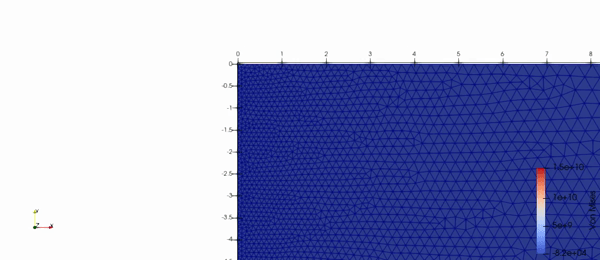

Usando este caso de estudio se realizaron pruebas de simulaciones asumiendo el material únicamente como un sólido elástico con el fin de explorar las condiciones de contorno, sin embargo, dada la dificultad de calibrar y validar dicho caso, se opta por simular un caso de estudio más general.

### __Problema de prueba 2: Consolidación de suelos__

Simulamos el ensayo de consolidación de suelos o caso de terzaghi. En la consolidación de terzaghi tenemos una muestra de material sometida a una carga constante con un drenaje en la misma frontera de la carga, con lo que se espera que la carga inicial que soporta la presión de poros se disipe en el tiempo.

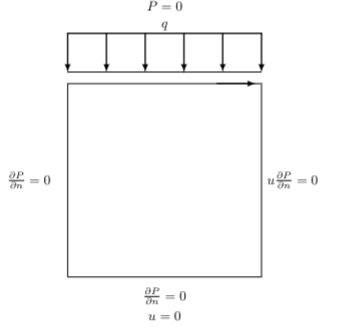

El modelo presenta problemas de divergencia en la solución debido a la incapacidad de disipar la energía a la cual se somete (con las condiciones de contorno).

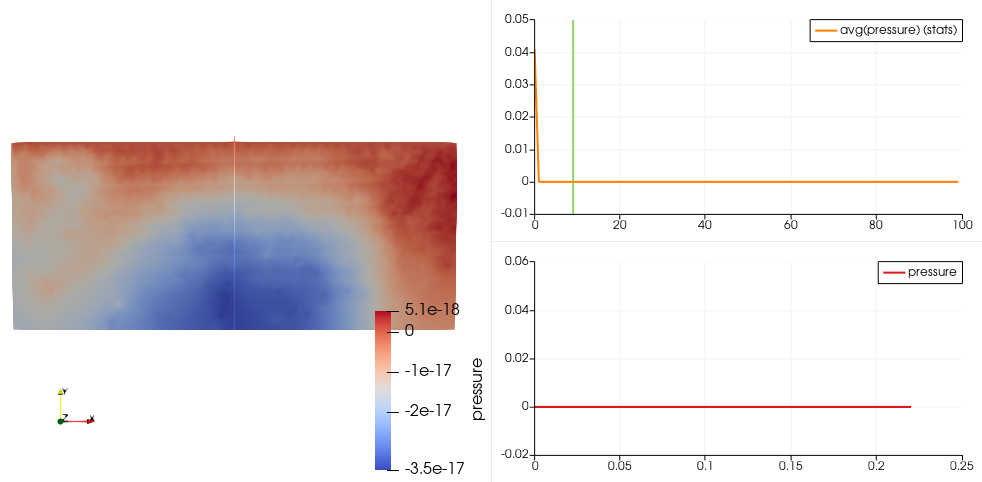

Por lo que se  replantea el modelo reológico del suelo añadiendo un término de amortiguación viscosa dentro del tensor de tensiones:

$\sigma_{e}(u_s)=\lambda\,\hbox{tr}\,(\varepsilon) I + 2\mu\varepsilon + A \frac{\partial \epsilon}{\partial t}$

Siendo $A$ el coeficiente de amortiguación.

La nueva formulación variacional resulta en:

\begin{align}
\int_{\Omega} \nabla \boldsymbol{\sigma} : \nabla \boldsymbol{v} dx- \int_{\Omega} \alpha p (\nabla \cdot \boldsymbol{v}) dx + \int_{\Omega}A\frac{(\nabla \sigma_e \cdot \nabla v)_{n}-(\nabla \sigma_e \cdot \nabla v)_{n-1}}{\Delta t} d \Omega=& \int_{\Omega} \boldsymbol{f}\cdot\boldsymbol{v}\: dx +\int_{\partial\Omega} (\boldsymbol{n} \cdot \boldsymbol{\sigma})\cdot\boldsymbol{v} d\partial ds ,\\
\int_{\Omega} s \frac{p_{n}-p_{n-1}}{\Delta t} w\: dx + \int_{\Omega} \alpha \frac{\nabla \cdot (\boldsymbol{u}_{n}-\boldsymbol{u}_{n-1})}{\Delta t}w\:dx + \int_{\Omega} \nabla w \cdot \frac{k}{\mu} \nabla p \: dx = & -\int_{\partial\Omega} \frac{k}{\mu}pn w\; ds.
\end{align}


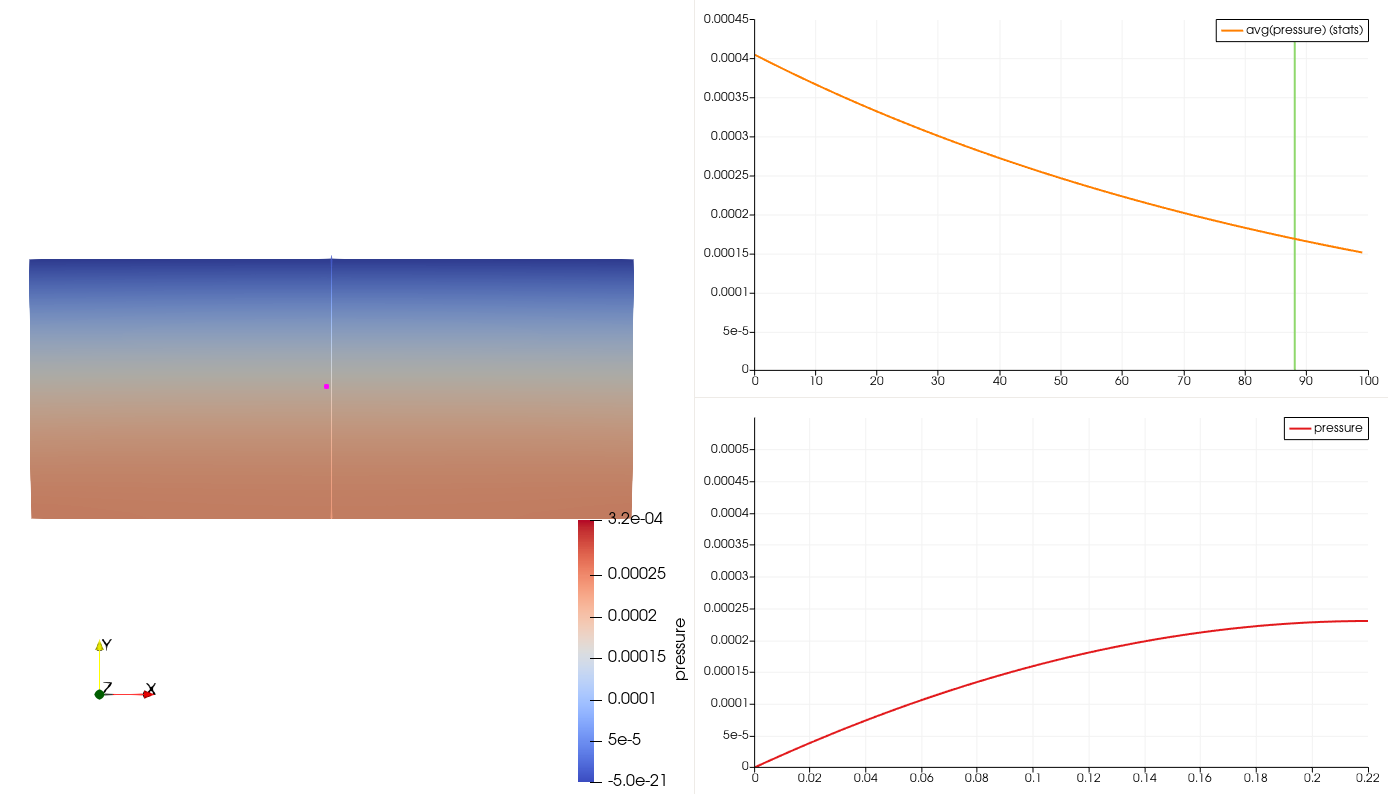

El código completo para el problema de prueba de consolidación de suelos se ve como sigue:

In [ ]:
from ast import Constant
import os

from fenics import*
from matplotlib import pyplot
from ufl import nabla_div, nabla_grad, elem_op
import numpy as np
from ufl.tensors import as_matrix

# Problem definitions
E=Constant(310000)  #Elastic modulus
C=Constant(15530)  #Cohesion
rho=Constant((8000)) #densidad
nu=Constant(0.25) #Poisson
mu = E/2/(1+nu) #Lame
lmbda = E*nu/((1+nu)*(1-2*nu))#Lame
K=Constant(((1,0),(0,1)))
f = Constant((0, 0))
B_s=1E-11
B_m=1E-10
B_f=4.4E-10
gamma=1-B_s/B_m #biotcoef
r=0.45
Poro=0.05
s_coef=(gamma-Poro)*B_s +Poro*B_f #storange coef
flo=Constant((0,0)) # condicion de flujo impermeable
T=Constant((0,-10000)) #traccion 

#Transient analysis
steps =100
t=0 
Ti=1
delta= Ti/steps
dt=Constant((delta))

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
n=FacetNormal(mesh)

#Define Dirichlet BC boundary
def boundary_B(x, on_boundary):
    return near(x[1],0)

#Define Dirichlet BC boundary
def boundary_T(x, on_boundary):
    return near(x[1],1)

#Define Neumann BC boundary
class BoundaryN(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1)

boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
bn = BoundaryN()
bn.mark(boundary_markers, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

#Define approximation spaces
ele_p  = FiniteElement("P",  mesh.ufl_cell(), 1) # pressure
ele_u  = VectorElement("P",  mesh.ufl_cell(), 2) # solid displacement
W = MixedElement([ele_p, ele_u])
W = FunctionSpace(mesh, W)
U = TrialFunction(W)
V = TestFunction(W)

#Define functions
p, u = split(U)
q, v = split(V)
X_n = Function(W)
p_n, u_n = split(X_n)

# Dirichlet boundary condition imposition
bp1=DirichletBC(W.sub(0),Constant((0)),boundary_T)
bc2 = DirichletBC(W.sub(1), Constant((0,0)),boundary_B)
bcs=[bc2,bp1]

#Variational definitions

#Strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    
#Stress
def sigma(u):
    d = u.geometric_dimension()
    return lmbda*div(u)*Identity(d) + 2*mu*epsilon(u)

#Variational forms

F1 = dt*inner(sigma(u), epsilon(v))*dx - dt*gamma*p*nabla_div(v)*dx\
    - dt*inner(f, v)*dx + inner((sigma(u)-sigma(u_n)), epsilon(v))*dx\
    - dt*inner(T, v)*ds(0)
F2 = dt*inner(nabla_grad(q), K*nabla_grad(p))*dx +\
    gamma*(nabla_div(u)-nabla_div(u_n))*q*dx +s_coef*(p-p_n)*q*dx\
        -dt*inner(flo,n)*q*ds 

L_momentum =lhs(F1)
R_momentum =rhs(F1)
L_mass=lhs(F2)
R_mass=rhs(F2)

L= L_mass+L_momentum
R= R_mass+R_momentum


for pot in range(steps):
    print('step', pot, 'of', steps,'time:',t)

    X = Function(W)
    solve(L==R,X,bcs)
    p_, u_ = split(X)
    X_n.assign(X)
   
    t=t+delta


In [ ]:
plot(u_)

In [ ]:
plot(p_)

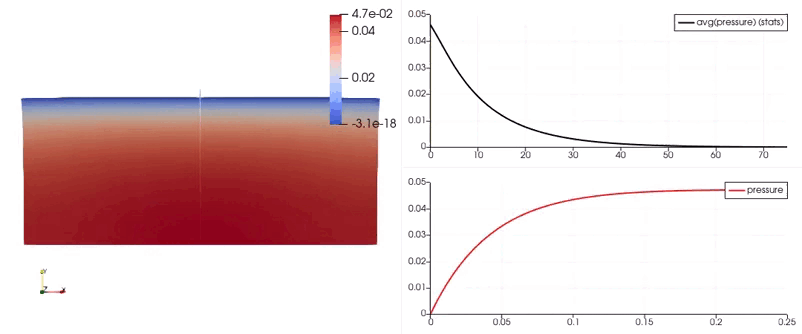